### Exploratory Data Analysis

In this section, a variety of variables are looked at more closely to understand basic trends to give direction on how to create a Linear Regression model to best analyzie the data. Sometimes insights made will lead us back to data cleaning or refining our original model.

----

In [115]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pickle

%matplotlib inline

Loading Dataset from Data Cleaning section...

In [116]:
df = pickle.load(open('./pickles/Clean_DataFrame.pkl', 'rb'))

In [117]:
df

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,72.774648,13517,Pave,none,IR1,Lvl,...,0,0,none,none,none,0,3,2010,WD,130500
1,544,531379050,60,RL,43.000000,11492,Pave,none,IR1,Lvl,...,0,0,none,none,none,0,4,2009,WD,220000
2,153,535304180,20,RL,68.000000,7922,Pave,none,Reg,Lvl,...,0,0,none,none,none,0,1,2010,WD,109000
3,318,916386060,60,RL,73.000000,9802,Pave,none,Reg,Lvl,...,0,0,none,none,none,0,4,2010,WD,174000
4,255,906425045,50,RL,82.000000,14235,Pave,none,IR1,Lvl,...,0,0,none,none,none,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.000000,11449,Pave,none,IR1,HLS,...,0,0,none,none,none,0,1,2008,WD,298751
2047,785,905377130,30,RL,66.930233,12342,Pave,none,IR1,Lvl,...,0,0,none,none,none,0,3,2009,WD,82500
2048,916,909253010,50,RL,57.000000,7558,Pave,none,Reg,Bnk,...,0,0,none,none,none,0,3,2009,WD,177000
2049,639,535179160,20,RL,80.000000,10400,Pave,none,Reg,Lvl,...,0,0,none,none,none,0,11,2009,WD,144000


Understanding basic shape and summary stats on our dependent variable 'saleprice'

In [118]:
df['saleprice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

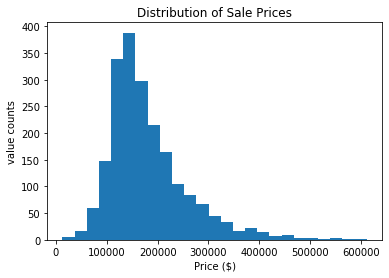

In [119]:
plt.hist(df['saleprice'], bins = 25);
plt.title('Distribution of Sale Prices');
plt.xlabel('Price ($)')
plt.ylabel('value counts')

plt.savefig("./assets/saleprice_hist.png")

We can see that most houses in this data set are between 100,000 and 200,000 dollars.

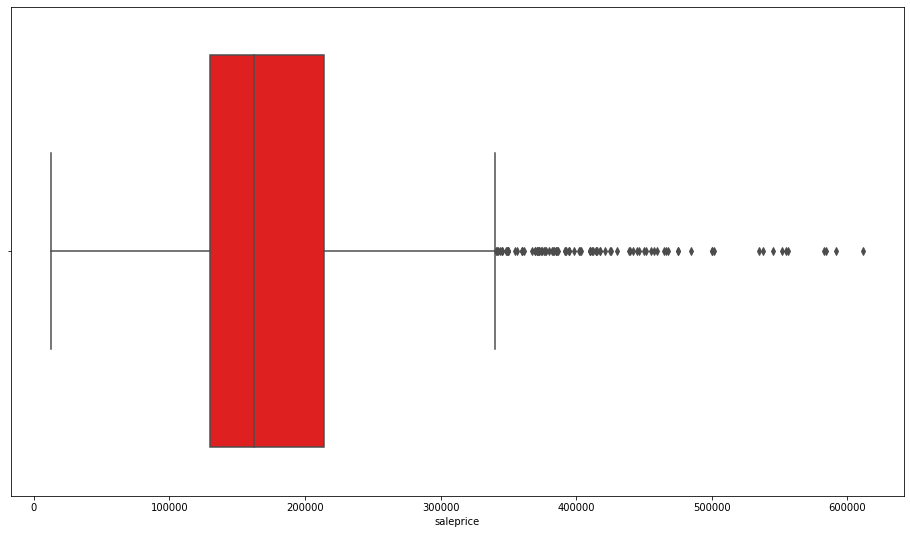

In [120]:
plt.figure(figsize=(16, 9))
sns.boxplot(df['saleprice'], color ='r');

plt.savefig("./assets/saleprice_boxplot.png")

### Determining variable Relationships

The goal behind the following steps is to figure out correlations between each column compared with saleprice. Finding variables with high correlation with sale price are a good starting point to know what variables to include in our models.

Only finding correlations for **numerical variables** for now since strings variables cannot be correlated.

In [121]:
numeric_df = df.select_dtypes(exclude='object')

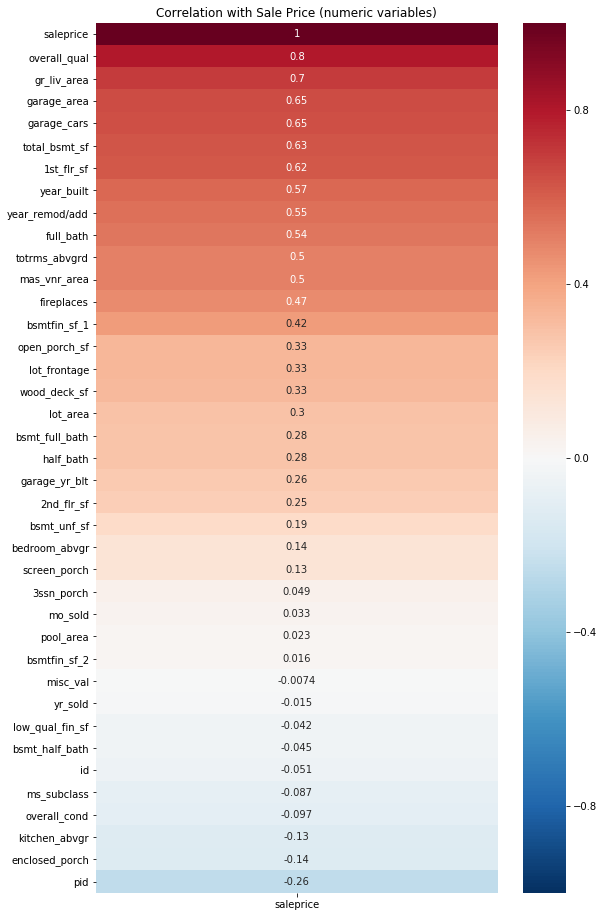

In [122]:
#correlation heatmap of all NUMERIC variables
plt.figure(figsize=(9,16))
plt.title('Correlation with Sale Price (numeric variables)');
sns.heatmap(numeric_df.corr()[['saleprice']].sort_values('saleprice', ascending = False),  cmap = "RdBu_r", vmin=-1, vmax=1,  annot=True);
plt.savefig("./assets/numeric_heatmap.png")

Now that we can see what numerical variables have a relationship to salesprice, we will plot indivudal variables to sale price to see specific relationships. I will only look at relationships with a correlation > 0.5 which are relatively strong correlations.

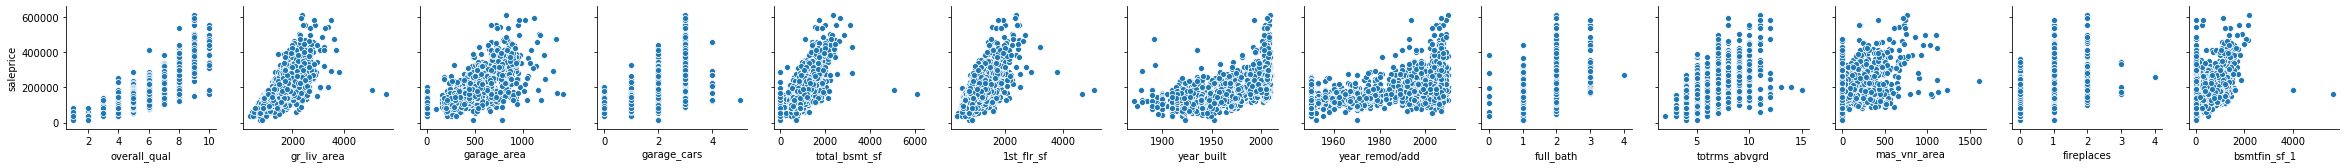

In [123]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['overall_qual', 'gr_liv_area', 'garage_area', 'garage_cars', 
                                                   'total_bsmt_sf', '1st_flr_sf', 'year_built', 'year_remod/add','full_bath', 'totrms_abvgrd','mas_vnr_area', 'fireplaces', 
                                                  'bsmtfin_sf_1']);
plt.savefig("./assets/pairplot.png")

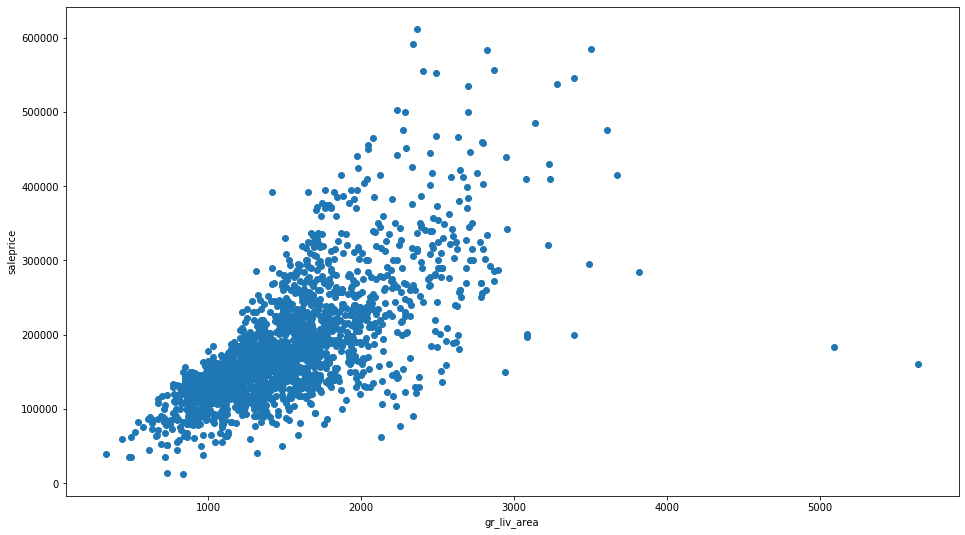

In [124]:
plt.figure(figsize=(16, 9))
plt.scatter(df['gr_liv_area'],df['saleprice']);
plt.xlabel('gr_liv_area');
plt.ylabel('saleprice');
plt.savefig("./assets/grlivarea vs price.png")

Per the data dictionary, we will drop the two houses with over 5000 sqr_ft that sold for marginally low prices. These were likely partial sales that don't reflect prices well.

In [125]:
df[df['gr_liv_area'] > 5000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,none,IR3,Bnk,...,0,480,Gd,none,none,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,none,IR1,Bnk,...,0,0,none,none,Elev,17000,10,2007,New,183850


In [126]:
#drop outliers which were sales above 5000 sq ft
df.drop(index = [960, 1885], inplace= True)

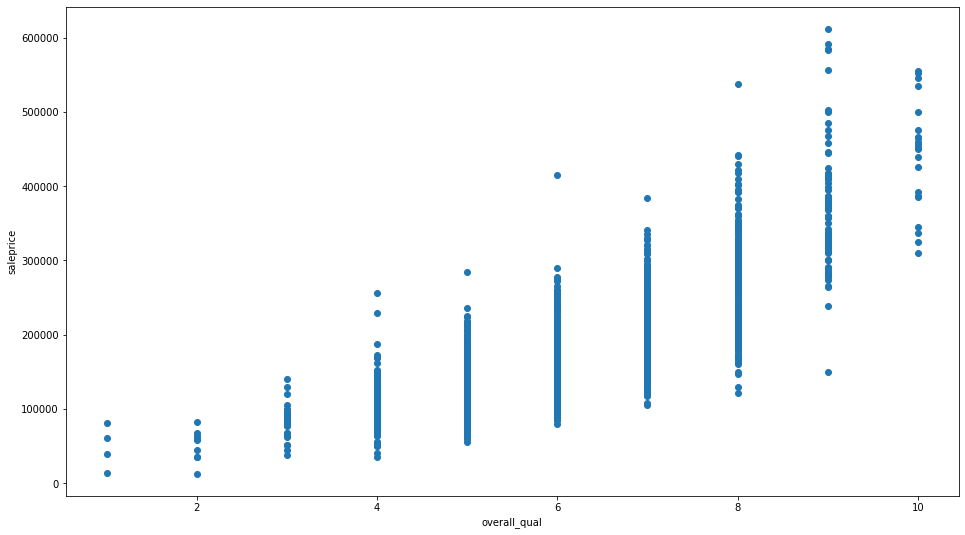

In [127]:
plt.figure(figsize=(16, 9))
plt.scatter(df['overall_qual'],df['saleprice']);
plt.xlabel('overall_qual');
plt.ylabel('saleprice');
plt.savefig("./assets/overalqual vs price.png")

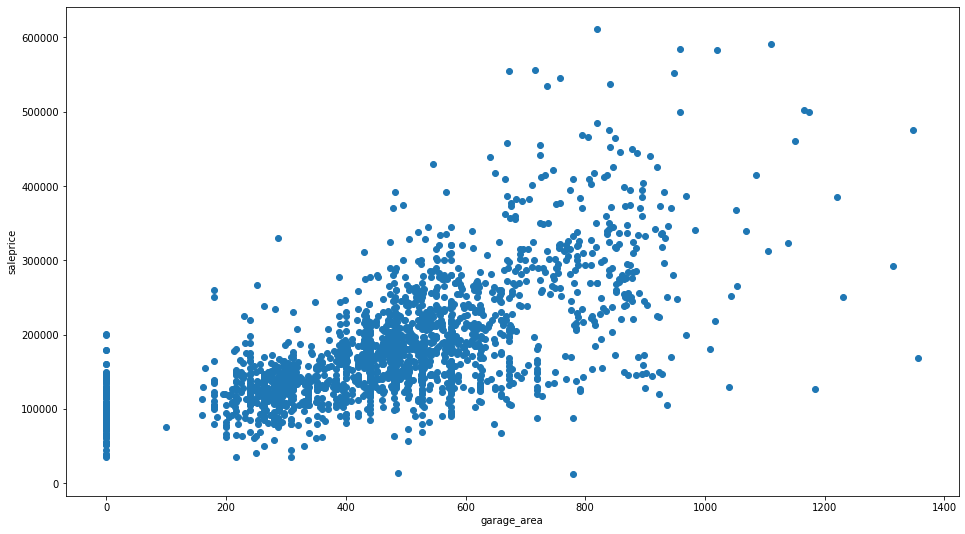

In [128]:
plt.figure(figsize=(16, 9))
plt.scatter(df['garage_area'],df['saleprice']);
plt.xlabel('garage_area');
plt.ylabel('saleprice');
plt.savefig("./assets/garagearea vs price.png")

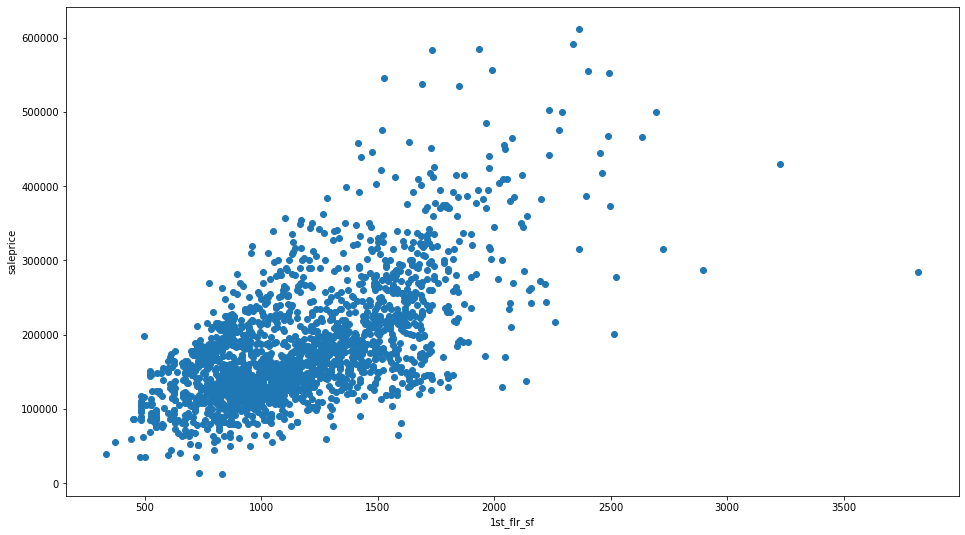

In [129]:
plt.figure(figsize=(16, 9))
plt.scatter(df['1st_flr_sf'],df['saleprice']);
plt.xlabel('1st_flr_sf');
plt.ylabel('saleprice');
plt.savefig("./assets/1st flr vs price.png")

Dropping 1st_flr square feet over 3500 that was very underpriced because it was likely a partial sale

In [130]:
df[df['1st_flr_sf'] > 3500]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
616,1498,908154080,20,RL,123.0,47007,Pave,none,IR1,Lvl,...,0,0,none,none,none,0,7,2008,WD,284700


In [131]:
#dropping outlier  of 1st floor sqft above 3500
df.drop(index = 616, inplace= True)

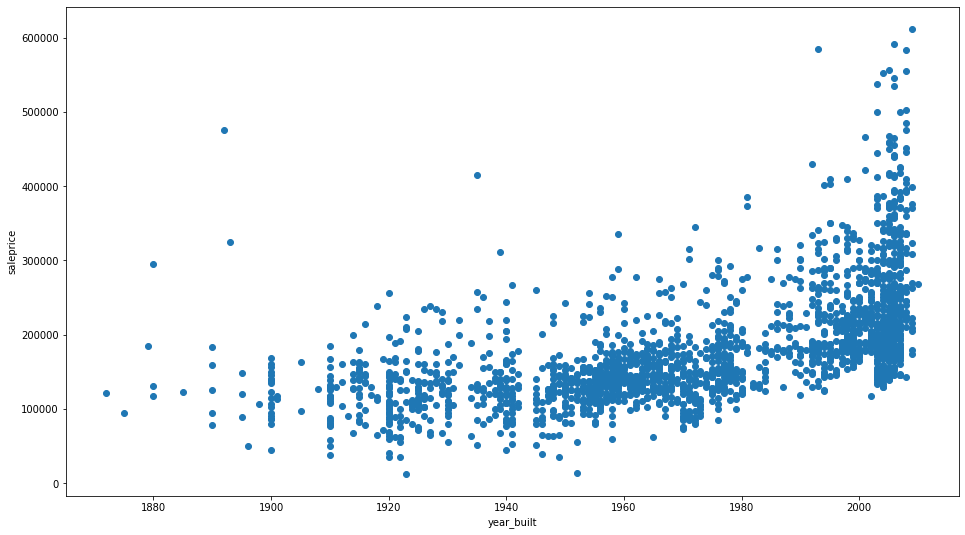

In [132]:
plt.figure(figsize=(16, 9))
plt.scatter(df['year_built'],df['saleprice']);
plt.xlabel('year_built');
plt.ylabel('saleprice');
plt.savefig("./assets/year built vs price.png")

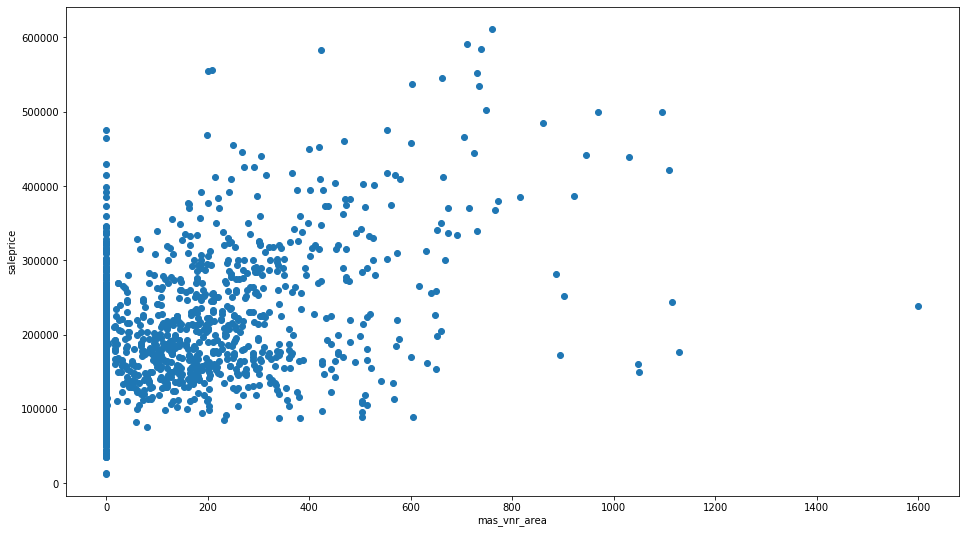

In [133]:
plt.figure(figsize=(16, 9))
plt.scatter(df['mas_vnr_area'],df['saleprice']);
plt.xlabel('mas_vnr_area');
plt.ylabel('saleprice');

Now finding correlations for all **categorical** variables to sale price.

In [134]:
categorical_df = df.select_dtypes(include='object')
categorical_df

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,...,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type
0,RL,Pave,none,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,none,Attchd,RFn,TA,TA,Y,none,none,none,WD
1,RL,Pave,none,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,Attchd,RFn,TA,TA,Y,none,none,none,WD
2,RL,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,none,Detchd,Unf,TA,TA,Y,none,none,none,WD
3,RL,Pave,none,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,none,BuiltIn,Fin,TA,TA,Y,none,none,none,WD
4,RL,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,none,Detchd,Unf,TA,TA,N,none,none,none,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,RL,Pave,none,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Gd,Attchd,Fin,TA,TA,Y,none,none,none,WD
2047,RL,Pave,none,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,none,Detchd,Unf,TA,TA,Y,none,none,none,WD
2048,RL,Pave,none,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,...,TA,Detchd,Unf,Fa,Fa,Y,none,none,none,WD
2049,RL,Pave,none,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Gd,Attchd,Unf,TA,TA,Y,none,none,none,WD


Converting all categorical variables into dummy variables so that can be analyzed with correlations.

In [135]:
categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
    
categorical_df['saleprice']= df['saleprice']
    
categorical_df.columns = [column_name.lower().replace(' ','_') for column_name in categorical_df.columns]

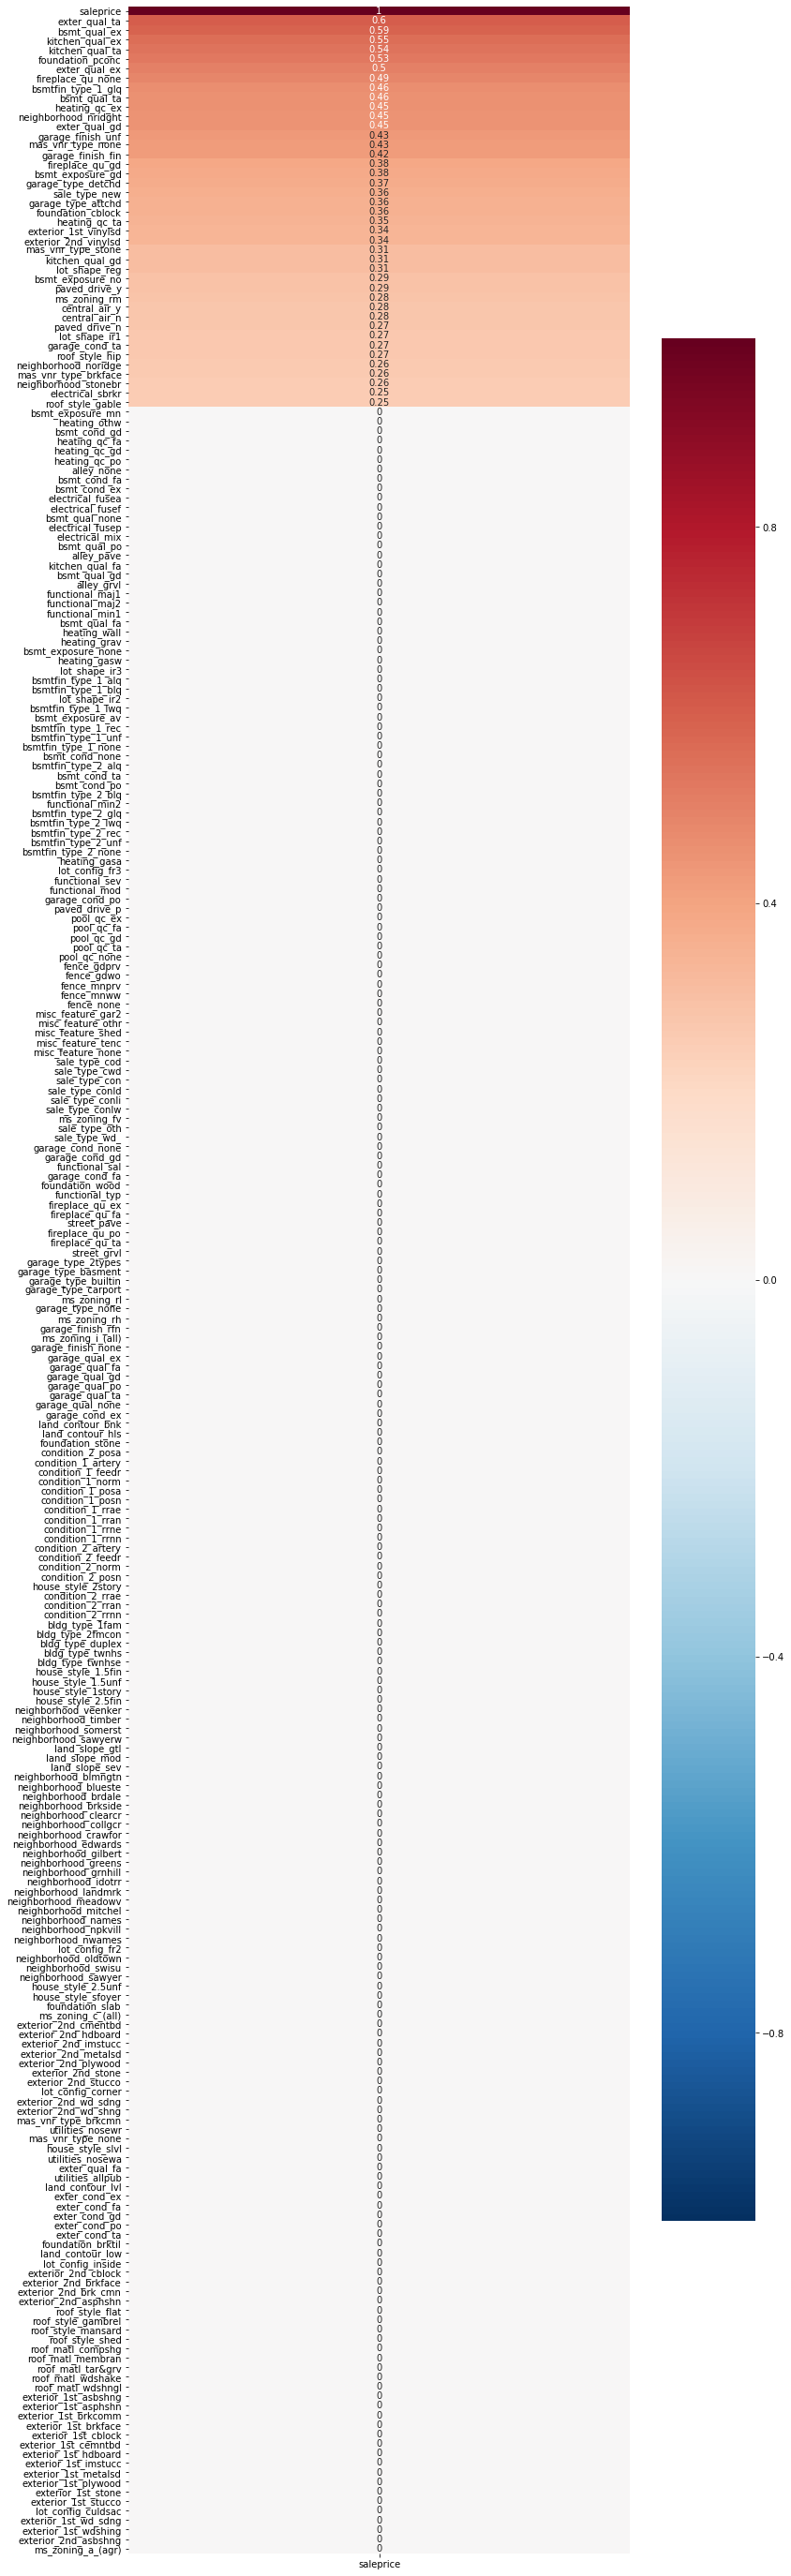

In [136]:
categorical_dummies_corr = categorical_df.corr()
categorical_dummies_corr[np.abs(categorical_dummies_corr)<.25] = 0

#correlation heatmap of all categorical variables
plt.figure(figsize=(12,50))
sns.heatmap(abs(categorical_dummies_corr[['saleprice']]).sort_values('saleprice', ascending = False),  cmap = "RdBu_r", vmin=-1, vmax=1,  annot=True);

### Organizing important ordinal variables that will be included in my Model

Based on the correlation heatmap, I've determined that 'bsmt_qual', 'ext_qual', 'kitchen_qual' have correlations with saleprice. Those all happen to be ordinal variables, so I will change them into scales that can be analyzed by a model.

In [137]:
bsmt_qual_dict = dict(zip(['none', 'Po', 'Fa', 'TA','Gd', 'Ex'], range(6)))
df['bsmt_qual'] = df['bsmt_qual'].apply(lambda x:bsmt_qual_dict[x])

kitchen_qual_dict = dict(zip(['Po', 'Fa', 'TA','Gd', 'Ex'], range(1, 6)))
df['kitchen_qual'] = df['kitchen_qual'].apply(lambda x:kitchen_qual_dict[x])

exter_qual_dict = dict(zip(['Po', 'Fa', 'TA','Gd', 'Ex'], range(1, 6)))
df['exter_qual'] = df['exter_qual'].apply(lambda x:exter_qual_dict[x])

heating_qc_dict = dict(zip(['Po', 'Fa', 'TA','Gd', 'Ex'], range(1, 6)))
df['heating_qc'] = df['heating_qc'].apply(lambda x:heating_qc_dict[x])



### Checking for Multicollinearity

Some of the variables that correlate with sale price seem to be very similar variables. Check correlation between variables to decide what I might drop.

In [138]:
features =['overall_qual', 'gr_liv_area', 'garage_area', 'garage_cars', 
        'total_bsmt_sf', '1st_flr_sf', 'year_built', 'year_remod/add','full_bath', 'totrms_abvgrd','mas_vnr_area', 'fireplaces', 
        'bsmtfin_sf_1', 'bsmt_qual', 'exter_qual', 'kitchen_qual']
df[features]


,overall_qual,gr_liv_area,garage_area,garage_cars,total_bsmt_sf,1st_flr_sf,year_built,year_remod/add,full_bath,totrms_abvgrd,mas_vnr_area,fireplaces,bsmtfin_sf_1,bsmt_qual,exter_qual,kitchen_qual
0,6,1479,475.0,2.0,725.0,725,1976,2005,2,6,289.0,0,533.0,3,4,4
1,7,2122,559.0,2.0,913.0,913,1996,1997,2,8,132.0,1,637.0,4,4,4
2,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,5,0.0,0,731.0,3,3,4
3,5,1444,400.0,2.0,384.0,744,2006,2007,2,7,0.0,0,0.0,4,3,3
4,6,1445,484.0,2.0,676.0,831,1900,1993,2,6,0.0,0,0.0,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,1728,520.0,2.0,1884.0,1728,2007,2007,2,7,0.0,1,1011.0,4,4,4
2047,4,861,539.0,2.0,861.0,861,1940,1950,1,4,0.0,0,262.0,3,3,3
2048,6,1913,342.0,2.0,896.0,1172,1928,1950,1,9,0.0,1,0.0,3,3,3
2049,4,1200,294.0,1.0,1200.0,1200,1956,1956,1,6,0.0,2,155.0,3,3,3


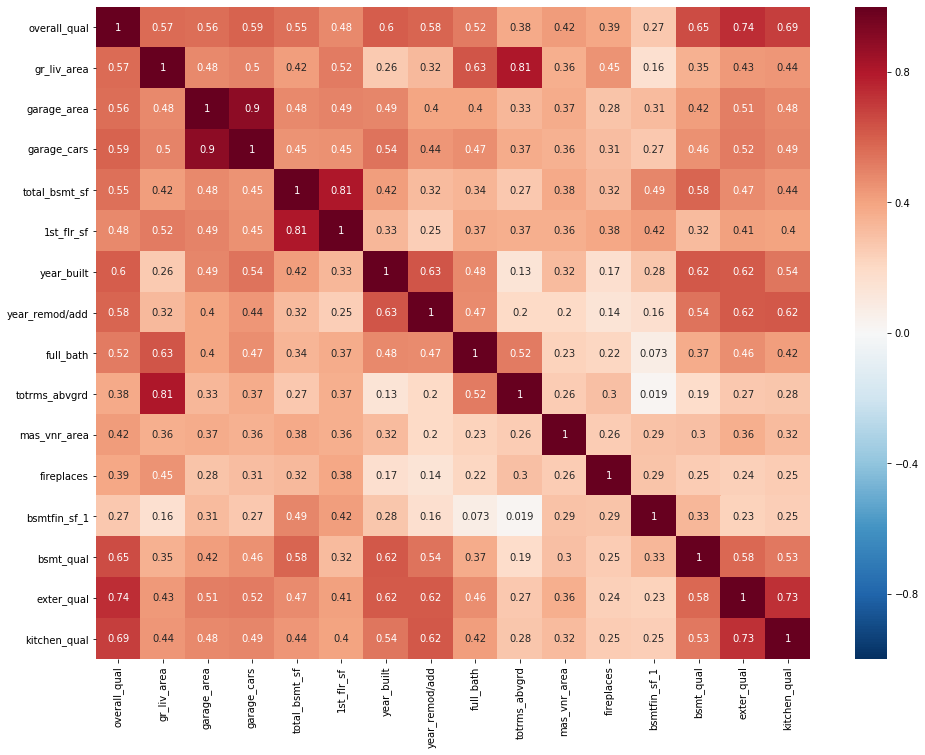

In [139]:
plt.figure(figsize=(16,12))
sns.heatmap(df[features].corr(), cmap = "RdBu_r", vmin=-1, vmax=1,  annot=True);
plt.savefig("./assets/multicoll.png")

In [140]:
df[features].corr().shape

(16, 16)